In [1]:
import os 
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
os.chdir("C:/Users/manue/Downloads/prueba_DS/")
file = "prueba_DS.txt"

df = pd.read_csv(file)

# Solución Ejercicio Colombina


En este ejercicio se aborda el problema descrito en el documento "**Prueba Científico de Datos Colombina**". A continuacion se describen los pasos realizados para abordar el problema:

1. Se realiza una reflexion sobre la forma de abordar el problema 
2. Se construye la variable objetivo
3. Se ajusta el data frame para los ejercicios de modelacion
4. Se entrenan los modelos y se evalua su rendimiento
5. Importancia de variables y conclusiones

In [2]:
print(df.shape) # Dimensiones del data set 12559901 filas y 9 columnas
print(df.dtypes) # Tipos de variables 
df.head()  # Exploracion visual del data frame

(12559901, 9)
Doc_vtas      int64
Fecha        object
Solic         int64
Material      int64
Cnt_uni     float64
sect_mat      int64
Cnt_cart    float64
ValN_Pos    float64
Moneda       object
dtype: object


,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda
0,7503277849,2021-11-01,18134244,28424,72.0,42,1.000,347.76,COP
1,7503277849,2021-11-01,18134244,26780,6.0,42,6.000,781.40,COP
2,7503277849,2021-11-01,18134244,28846,72.0,42,1.000,309.05,COP
3,7503277849,2021-11-01,18134244,6572,18.0,42,0.375,124.59,COP
4,7503277849,2021-11-01,18134244,28850,1.0,42,1.000,478.87,COP


## Reflexion del problema

El objetivo es el siguiente:

+ Colombina está interesado en saber qué clientes tienen mayor probabilidad de no volver a comprar ninguno de sus productos. El negocio ha establecido que un cliente que no compra durante 2 meses es un cliente fugado.

El mensaje anterior nos indica que desean conocer de todos sus clientes quienes tienen la mayor probabilidad de "fugarse". En este caso nos indican que un cliente que se fuga ha dejado de comprar durante dos meses, sin embargo no se nos informa si son consecutivos o no. **En este ejercicio asumimos que el cliente deja de comprar por dos meses consecutivos**. Por otra parte, es un problema de clasificacion supervisado, debido a que tenemos un conocimiento *a priori* de cuales clientes son fugados (aquellos que dejan de comprar por dos meses consecutivos)

## Construccion de la variable objetivo 

Debido a que se debe identificar cuales clientes son fugados y cuales no, se crea una funcion denominada **fholes**, la cual busca para cada Cliente si existe en su historial de compras si existe dos meses consecutivos en los cuales deja de comprar. El procedimiento realizado es el siguiente:

1. Es necesario agregar los meses a nivel mensual
2. Las fechas se pasan de dias a meses
3. Se agrega el df
4. Se realiza un reshape long to wide para que cada mes sea una columna
5. Se aplica la funcion **fholes** a cada fila y cada una se etiqueta como 0 o 1 segun corresponda
6. el df queda listo para utilizar en los modelos de clasificacion

Mas adelante se explica el proceso en detalle de la funcion **fholes**

In [3]:
df['date'] =  pd.to_datetime(df['Fecha'], format='%Y-%m-%d')

In [4]:
df['date'] = df['date'].dt.to_period("M")

In [5]:
pdata = df.groupby(['date','Solic']).size().to_frame('size').reset_index()
pdata

,date,Solic,size
0,2021-11,49128,86
1,2021-11,69792,18
2,2021-11,69868,46
3,2021-11,70430,20
4,2021-11,70566,37
...,...,...,...
565749,2022-07,18179654,15
565750,2022-07,18179660,24
565751,2022-07,18179662,8
565752,2022-07,18179664,20


In [6]:
pdata = pdata.pivot(index='Solic',columns='date',values='size')
pdata['Solic'] = pdata.index
pdata

date,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,Solic
Solic,,,,,,,,,,
49128,86.0,11.0,41.0,83.0,58.0,61.0,72.0,48.0,32.0,49128
69792,18.0,19.0,34.0,26.0,28.0,22.0,19.0,24.0,5.0,69792
69838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,69838
69868,46.0,52.0,43.0,50.0,42.0,30.0,59.0,33.0,26.0,69868
70334,NaN,NaN,NaN,27.0,10.0,NaN,10.0,NaN,NaN,70334
...,...,...,...,...,...,...,...,...,...,...
18179654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,18179654
18179660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,18179660
18179662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,18179662


In [7]:
def fholes(y):
    temp = pdata[(pdata['Solic'] == y)]
    holes = temp.isna().any().reset_index()   
    holes['desertor'] = 0
    value = sum(holes[holes.columns[1]][0:9])
    if value >= 5:
        holes['desertor'] = 1
    if value >= 2 and value < 5:
        if ( 1 not in holes['desertor'].unique()):
            for x in range(0,8):
                if holes[holes.columns[1]][x] == True:
                    if holes[holes.columns[1]][x+1] == True:
                        holes['desertor'] = 1
    pdata.loc[pdata['Solic'] == y, 'desertor'] = holes['desertor'][1]
    #print(pdata[(pdata['Solic'] == y)].head())

### Funcion fholes

Esta funcion toma cada fila (Cliente) dentro del df pdata y segun dos condiciones determina si es un cliente fugado o no. Las condiciones son:

* No realiza compras en 5 o mas meses, deacuerdo a la longitud del periodo analizado (9 meses) si no realiza compras en 5 o mas meses, debe haber dejado de comprar en 2 consecutivos
* Examina los 8 primero meses y busca si dejo de comprar en dos meses consecutivos. 
* En caso de encontrar un cliente fugado lo marca como 1, en otro caso es un 0

In [8]:
pdata['Solic'].apply(fholes)

Solic
49128       None
69792       None
69838       None
69868       None
70334       None
            ... 
18179654    None
18179660    None
18179662    None
18179664    None
18179668    None
Name: Solic, Length: 80294, dtype: object

In [9]:
obj = pdata[['desertor']]
obj.reset_index(inplace = True)
obj

date,Solic,desertor
0,49128,0.0
1,69792,0.0
2,69838,1.0
3,69868,0.0
4,70334,1.0
...,...,...
80289,18179654,1.0
80290,18179660,1.0
80291,18179662,1.0
80292,18179664,1.0


## Preprocesamiento de los datos 

Los datos suministrados contienen nueve columnas las cuales son:

* Doc_vtas: identificador de la venta
* Fecha: fecha de venta en frecuencia diaria
* Solic: identificador del cliente
* Material: codigo del producto vendido
* Cnt_uni: Cantidad pedida en unidad venta
* sect_mat: código del sector del producto
* Cnt_cart: Cantidad pedidos en unidad cartón
* VaIN_Pos: Valor neto en dinero
* Moneda: Moneda

Lo primero que se debe notar es que los datos tienen una frecuencia diaria y una misma factura o venta puede tener varios productos relacionados. 

In [10]:
df.head()

,Doc_vtas,Fecha,Solic,Material,Cnt_uni,sect_mat,Cnt_cart,ValN_Pos,Moneda,date
0,7503277849,2021-11-01,18134244,28424,72.0,42,1.000,347.76,COP,2021-11
1,7503277849,2021-11-01,18134244,26780,6.0,42,6.000,781.40,COP,2021-11
2,7503277849,2021-11-01,18134244,28846,72.0,42,1.000,309.05,COP,2021-11
3,7503277849,2021-11-01,18134244,6572,18.0,42,0.375,124.59,COP,2021-11
4,7503277849,2021-11-01,18134244,28850,1.0,42,1.000,478.87,COP,2021-11


En este punto, se decide crear indicadores a nivel de Cliente, por lo que se decide agregar las variables Cnt_uni,Cnt_cart y VaIN_Pos segun el Cliente y el producto, se asume que el codigo de sector no varia por producto. La moneda no varia por lo que esta no se incluye.

In [11]:
dfa = df.drop(['Doc_vtas', 'Fecha','date','sect_mat'], axis=1).groupby(['Solic','Material']).sum().reset_index()
dfa

,Solic,Material,Cnt_uni,Cnt_cart,ValN_Pos
0,49128,296,1.0,0.055556,37.84
1,49128,354,9.0,0.500001,451.77
2,49128,436,1.0,0.055556,60.24
3,49128,1246,50.0,2.777780,2709.77
4,49128,2458,1.0,0.062500,41.03
...,...,...,...,...,...
4288137,18179668,40050,1.0,0.055556,47.64
4288138,18179668,54274,1.0,0.041667,39.31
4288139,18179668,54336,1.0,0.041667,36.32
4288140,18179668,56236,1.0,0.066667,56.93


Adicionalmente para ejecutar adecuadamente el modelo es necesario, que el data frame anterior, pase de formato long a wide, de esta forma cada columna representa a cada uno de las variables Cnt_uni,Cnt_cart y VaIN_Pos para cada uno de los materiales. Debido a que no todos los clientes solicitan los mismos productos, se tienen missing values estos se reemplazan por cero. 

In [12]:
dfa.Material  = dfa.Material.apply(str)
dfa = dfa.pivot(index='Solic',columns='Material').reset_index()
dfa = dfa.fillna(0)
dfa

Solic Cnt_uni                                                  \
Material             10000 10264 10416 10426 10428 10472 10502 10504 10558   
0            49128     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1            69792     0.0   0.0   0.0   0.0   0.0   0.0   6.0   0.0   0.0   
2            69838     0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
3            69868     0.0   0.0   0.0   0.0   0.0   0.0   4.0   4.0   0.0   
4            70334     1.0   0.0   0.0   0.0   0.0   0.0   2.0   5.0   0.0   
...            ...     ...   ...   ...   ...   ...   ...   ...   ...   ...   
80289     18179654     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
80290     18179660     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
80291     18179662     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
80292     18179664     8.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
80293     18179668     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

          ... ValN_Pos                                                    
Material  ...     9358    9388 9628 9630 9632   9634 9808 9966 9968 9982  
0         ...      0.0    0.00  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  
1         ...      0.0    0.00  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  
2         ...      0.0    0.00  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  
3         ...      0.0  203.28  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  
4         ...      0.0    0.00  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  
...       ...      ...     ...  ...  ...  ...    ...  ...  ...  ...  ...  
80289     ...      0.0    0.00  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  
80290     ...      0.0    0.00  0.0  0.0  0.0  47.37  0.0  0.0  0.0  0.0  
80291     ...      0.0    0.00  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  
80292     ...      0.0    0.00  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  
80293     ...      0.0    0.00  0.0  0.0  0.0   0.00  0.0  0.0  0.0  0.0  

[80294 rows x 2722 columns]

Se eliminan los didentificadores de cada columna, y se generar los grupos de train y test. Adicionalmente por problemas de memoria en mi equipo local es necesario eliminar algunos objetos como df, pdata, dfa, obj y unicamente se trabajara con los matrices de train, test y las Dmatrix especiales para la funcion **xbg.train** Inicialmente no se realizara ningun tipo de calibracion de hiperparametros o validacion cruzada por terminos de memoria y tiempo de computo. 

Para entrenar el modelo se utilizara la funcion xgb.train y el API de sklearn XGBClassifer. Adicionalmente se evidencia un problema de balanceo en las clases por lo que se ejecutan dos modelos, uno sin balancear y otro que utiliza ponderadores para darle mayor peso a los clientes que se fugan

In [13]:
dfa=dfa.drop(dfa.columns[[0]],axis = 1)
#obj=obj.drop(obj.columns[[0]],axis = 1)

In [14]:
del df ,pdata 
X_train, X_test, y_train, y_test = train_test_split(dfa, obj, random_state=0, train_size = .75)
dm_train = xgb.DMatrix(data=X_train,label=y_train['desertor'],enable_categorical=True)
dm_test = xgb.DMatrix(data=X_test,label=y_test['desertor'],enable_categorical=True)
#del dfa ,obj

In [15]:
solic = pd.concat([y_train['Solic'],y_test['Solic']])
y_train = y_train['desertor']
y_test = y_test['desertor']

In [16]:
params = {'objective':"binary:logistic", "max_depth":3}

In [17]:
# Se utiliza la funcion xgb.train para aprovechar la eficiencia de las matricecs DMatrix. 
xgb_model = xgb.train(params, dm_train)

In [18]:
# Se obtienen las probabilidades
preds = xgb_model.predict(dm_test)

In [19]:
# Se define el tamaño de los graficos
plt.rcParams["figure.figsize"] = (10,7)
#Se computa el AUC y los valores de la curva ROC
auc = roc_auc_score(y_test, preds)
fpr, tpr, thresholds = roc_curve(y_test, preds)

In [20]:
# Se generan las clasificaciones a partir de las probabilidades
classx = [1 if x > 0.5 else 0 for x in preds ]

In [21]:
# se calcula la matriz de confusion
cm = confusion_matrix(y_test, classx,normalize='true')

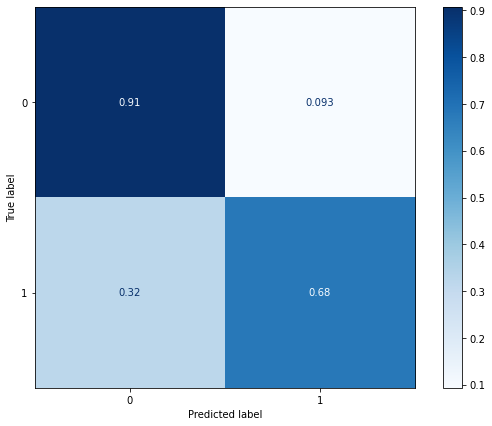

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88     13659
         1.0       0.77      0.68      0.72      6415

    accuracy                           0.83     20074
   macro avg       0.82      0.79      0.80     20074
weighted avg       0.83      0.83      0.83     20074



In [22]:
# Se presenta un reporte de la clasificacion y la matriz de confusion. 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, classx))

In [23]:
# Se calcula el ponderador y se utiliza en el clasificador, adicionalmente se habilita el uso de todos los nucleos del procesador
conteo_cp = np.array(y_train).sum()
conteo_cl = len(np.array(y_train)) - conteo_cp
spw = conteo_cl / conteo_cp

# Se define el clasificador, se utilizan los hiperparametros por default
model = XGBClassifier(scale_pos_weight=spw,n_jobs = -1)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [24]:
# Se predice la clase (es decir, se o no un cliente fugado)
#y_pred = model.predict(X_test)

In [25]:
# Se predicen las probabilidades de ser un cliente fugado
y_pred = model.predict_proba(X_test)

In [26]:
# A partir de las probabilidades se definen las clases usando un umbral del 0.5
classx2 = [1 if x > 0.5 else 0 for x in y_pred[:,1]]

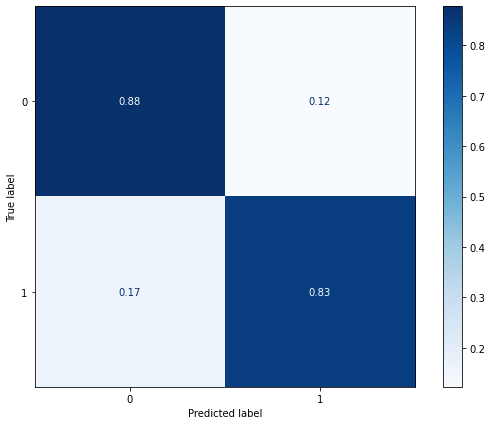

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     13659
         1.0       0.76      0.83      0.80      6415

    accuracy                           0.86     20074
   macro avg       0.84      0.86      0.85     20074
weighted avg       0.87      0.86      0.86     20074



In [27]:
# Matriz de confusion y reporte de clasificacion para el XGB Balanceado
cm = confusion_matrix(y_test, classx2,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, classx2))

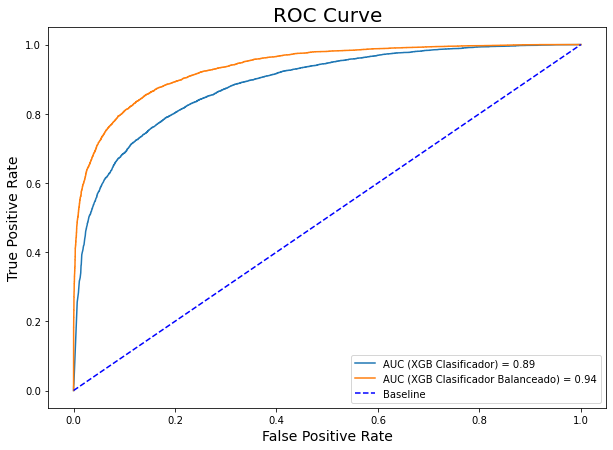

In [28]:
# Se computan el AUC y la curva ROC para el modelo balanceado
from sklearn.metrics import roc_auc_score, roc_curve
auc_b = roc_auc_score(y_test, y_pred[:,1])
fpr_b, tpr_b, thresholds = roc_curve(y_test, y_pred[:, 1])

# Se comparan las curvas ROC para ambos modelos. 
plt.plot(fpr, tpr, label=f'AUC (XGB Clasificador) = {auc:.2f}')
plt.plot(fpr_b, tpr_b, label=f'AUC (XGB Clasificador Balanceado) = {auc_b:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();

## Importancia de variables

En esta seccion se aborda brevemente la importancia de las variables encontradas. Se decide utilizar el metodo mas simple para calcular la importancia de variables el cual corresponde al aporte en la reduccion de impurezas en las clasificaciones. Existen otras medidas adicionales como la importancia mediante permutacion o los SHAP values, pero ambas alternativas aunque mas robustas son mas requieren mucho mas computo.

Aunque este metodo es sencillo, para lograr una representacion grafica de los datos es necesario obtener los nombres de los *features* debido a que estos vienen de un data frame multindex, debemos hacer algunos pasos extra para lograr ajustar los nombres y los valores.

In [29]:
# Se para cada indice de las columnas de entrenamiento se une con sus subniveles generando una concatencion 
nombres = [''.join(t) for t in X_train.columns]

['Cnt_uni27564', 'Cnt_uni27992', 'Cnt_uni25660', 'Cnt_uni27758', 'ValN_Pos24890', 'Cnt_uni28848', 'Cnt_cart24362', 'Cnt_cart13232', 'Cnt_uni28842', 'Cnt_cart24370']
[0.07428484 0.02436265 0.0110987  0.01095478 0.01051069 0.00990432
 0.00985223 0.00868781 0.00845489 0.00811078]


<AxesSubplot:ylabel='variables'>

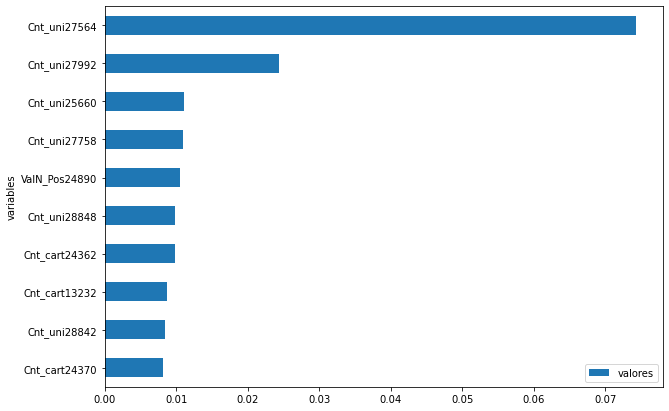

In [30]:
# Se obtienen las posiciones de mayor a menor aporte de cada feature
sorted_idx = np.argsort(-1*model.feature_importances_)
# Se guardan en un objeto los 10 mayores aportes
temp = []
for x in sorted_idx[0:10]:
    temp.append(nombres[sorted_idx[x]])
importantes = model.feature_importances_[sorted_idx[0:10]]
# se verifica la informacion 
print(temp[0:10])
print(importantes)
# se almacena en un diccionario
d = {'variables':temp[0:10], 'valores':importantes}
# se almacena en un dataframe
importancia = pd.DataFrame(data = d)
# se grafican en orden descendente
importancia.sort_values(ascending=True,by = "valores").plot.barh(x = 'variables', y = 'valores')

# Conclusion 

Los modelos entrenados logran metricas aceptables en la mayoria de indicadores, el modelo que utiliza ponderadores es aun mejor. La aproximacion anterior alcanza resultados buenos con modelos relativamente sencillos (No se realiza validacion cruzada, no se realiza calibracion de hiperparametros, no se utilizan muestras sinteticas para solucionar el balanceo), aun seria posible realizar algunos ejercicios adicionales para lograron mejores resultados. El modelo balanceado logra una prediccion promedio para ambas clases del 86%, mientras el modelo sin balancear tiene un 83%. Pero la diferencia fundamental radica en el recall, mientras este es 68% en el modelo sin balancear en el modelo balanceado es del 83%. Recordemos que el recall es el numero de positivos correctamente clasificados por el modelo dividido el numero total de positivos, basicamente indica la proporcion de clientes fugados que logra identificar en los datos de prueba. 

En cuanto a la importancia de variables, es dificil determinarla, el modelo tiene mas de 2 mil variables, pero se puede indicar que las cantidades vendidas en general ayudan a clasificar a los tipos de clientes, las ventas totales del producto 24890 y las unidades de carton de los productos 24362, 13232 y 24370 tambien estan presente en el ranking de las 10 variables mas importantes. 

Por otro lado, existe una literatura que utiliza redes de Long-Short-Term-Memory (LSTM) para abordar el problema de fuga de clientes de manera dinamica, no obstante en este documento se aborda de manera estatica. En caso el objetivo sea conocer cual cliente no comprara el siguiente mes un LSTM podria dar mejores respuestas. 

In [31]:
y_class = model.predict(pd.concat([X_train, X_test]))

In [32]:
cliente= pd.DataFrame(solic, columns=["Solic"])
fuga= pd.DataFrame(y_class, columns=["Fuga"])
class_f = pd.concat([cliente, fuga], axis=1)
class_f.to_csv('Resultado.csv', index = False)
